In [ ]:
import numpy as np
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [1]:
!pip install rouge-score sacrebleu evaluate torchsummary


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.2 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=7a4adbe864fe8ccb6bd42ae5cf313ba0997019ae4d4e798035d5e880476134bb
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
import re
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

from transformers import (
    T5Config, T5ForConditionalGeneration, T5Tokenizer,
    Seq2SeqTrainer, Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq
)

from datasets import Dataset
from sklearn.model_selection import train_test_split

import evaluate


In [2]:

df = pd.read_csv('/kaggle/input/datasetmed/medquad.csv')

df = df.drop(columns=['source', 'focus_area'])

df.rename(columns={'question': 'Question'}, inplace=True)
df.rename(columns={'answer': 'Answer'}, inplace=True)


df = df.drop_duplicates(subset=['Question', 'Answer']).reset_index(drop=True)


def clean_text(text):
    if pd.isna(text):  
        return ""
    text = re.sub(r"\(.*?\)", "", text)  
    text = re.sub(r'\s+', ' ', text).strip().lower() 
    return text


df[['Question', 'Answer']] = df[['Question', 'Answer']].astype(str).applymap(clean_text)


print("Valeurs nulles après nettoyage :\n", df.isnull().sum())


print(df.head())


<ipython-input-2-427a32e5ec46>:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[['Question', 'Answer']] = df[['Question', 'Answer']].astype(str).applymap(clean_text)


Valeurs nulles après nettoyage :
 Question    0
Answer      0
dtype: int64
                                 Question  \
0                      what is glaucoma ?   
1                  what causes glaucoma ?   
2     what are the symptoms of glaucoma ?   
3  what are the treatments for glaucoma ?   
4                      what is glaucoma ?   

                                              Answer  
0  glaucoma is a group of diseases that can damag...  
1  nearly 2.7 million people have glaucoma, a lea...  
2  symptoms of glaucoma glaucoma can develop in o...  
3  although open-angle glaucoma cannot be cured, ...  
4  glaucoma is a group of diseases that can damag...  


In [3]:

model_name = "t5-base"
config = T5Config.from_pretrained(model_name)
config.dropout_rate = 0.1
config.feed_forward_proj = "gelu"

model = T5ForConditionalGeneration.from_pretrained(model_name, config=config)
tokenizer = T5Tokenizer.from_pretrained(model_name)

model.resize_token_embeddings(len(tokenizer))

def summarize_model_by_type(model):
    layer_summary = defaultdict(int)
    param_summary = defaultdict(int)

    for _, module in model.named_modules():
        layer_type = type(module).__name__
        layer_summary[layer_type] += 1
        param_summary[layer_type] += sum(p.numel() for p in module.parameters())

    print(f"{'Layer Type':<30}{'Count':<10}{'Parameters':<15}")
    print("=" * 55)
    for layer_type, count in layer_summary.items():
        print(f"{layer_type:<30}{count:<10}{param_summary[layer_type]:<15,}")

summarize_model_by_type(model)


def preprocess_function(batch):
    inputs = [f"answer the following question: {q}" for q in batch['Question']]
    targets = [a for a in batch['Answer']]
    
    model_inputs = tokenizer(
        inputs, max_length=128, truncation=True, padding="max_length", return_tensors="pt"
    )
    
    labels = tokenizer(
        text_target=targets, max_length=64, truncation=True, padding="max_length", return_tensors="pt"
    )
    
    labels["input_ids"][labels["input_ids"] == tokenizer.pad_token_id] = -100
    model_inputs["labels"] = labels["input_ids"]
    
    return model_inputs


train_df, val_df = train_test_split(df, test_size=0.15, random_state=42)
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)


train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=train_dataset.column_names)
val_dataset = val_dataset.map(preprocess_function, batched=True, remove_columns=val_dataset.column_names)


training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_total_limit=2,
    learning_rate=6e-4,  
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    lr_scheduler_type="cosine_with_restarts",
    warmup_ratio=0.1,
    weight_decay=0.05,
    predict_with_generate=True,
    fp16=True,
    logging_dir="./logs",
    logging_steps=50,
    metric_for_best_model="exact_match",
    greater_is_better=True,
    report_to="none",
    gradient_accumulation_steps=2,
    max_grad_norm=0.5,
    optim="adamw_torch_fused",
    generation_max_length=64,
    generation_num_beams=6,
    dataloader_num_workers=4,
    group_by_length=True,
    remove_unused_columns=True,
    label_smoothing_factor=0.1
)


data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, padding='longest')


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds = [text.strip().lower() for text in decoded_preds]
    decoded_labels = [text.strip().lower() for text in decoded_labels]

    
    bleu = evaluate.load("bleu")
    rouge = evaluate.load("rouge")

  
    bleu_scores = bleu.compute(predictions=decoded_preds, references=[[label] for label in decoded_labels], max_order=4)
    bleu_1 = bleu_scores["precisions"][0]
    bleu_2 = bleu_scores["precisions"][1]
    bleu_3 = bleu_scores["precisions"][2]
    bleu_4 = bleu_scores["precisions"][3]

    
    rouge_score = rouge.compute(predictions=decoded_preds, references=decoded_labels)["rougeL"]

    exact_match = np.mean([p == l for p, l in zip(decoded_preds, decoded_labels)])

    return {
        "exact_match": exact_match,
        "BLEU-1": bleu_1,
        "BLEU-2": bleu_2,
        "BLEU-3": bleu_3,
        "BLEU-4": bleu_4,
        "ROUGE-L": rouge_score
      
    }



trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


trainer.train()


trainer.save_model("./t5_chatbot_model")
tokenizer.save_pretrained("./t5_chatbot_tokenizer")
torch.save(model.state_dict(), "./t5_chatbot_model.pth")


log_history = trainer.state.log_history




config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Layer Type                    Count     Parameters     
T5ForConditionalGeneration    1         222,882,048    
Embedding                     3         24,653,568     
T5Stack                       2         247,534,848    
ModuleList                    26        396,455,424    
T5Block                       24        198,227,712    
T5LayerSelfAttention          24        56,642,304     
T5Attention                   36        84,935,424     
Linear                        193       222,833,664    
T5LayerNorm                   62        47,616         
Dropout                       86        0              
T5LayerFF                     24        113,264,640    
T5DenseActDense               24        113,246,208    
ReLU                          24        0              
T5LayerCrossAttention         12        28,320,768     


Map:   0%|          | 0/13909 [00:00<?, ? examples/s]

Map:   0%|          | 0/2455 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-3-fb0990a3ad35>:141: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss,Exact Match,Bleu-1,Bleu-2,Bleu-3,Bleu-4,Rouge-l
1,3.001500,2.909919,0.141344,0.469386,0.308138,0.262318,0.236201,0.397316
2,2.868400,2.802818,0.142566,0.473063,0.312872,0.266921,0.240857,0.402327
3,2.708800,2.725047,0.145010,0.478219,0.315839,0.268555,0.242633,0.404187
4,2.552600,2.698787,0.144603,0.483445,0.319001,0.270835,0.244193,0.407995


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning

   Step  Exact Match    BLEU-1    BLEU-2    BLEU-3    BLEU-4   ROUGE-L
0   218     0.141344  0.469386  0.308138  0.262318  0.236201  0.397316
1   436     0.142566  0.473063  0.312872  0.266921  0.240857  0.402327
2   654     0.145010  0.478219  0.315839  0.268555  0.242633  0.404187
3   872     0.143381  0.482233  0.319932  0.272367  0.245644  0.407850
4  1085     0.144603  0.483445  0.319001  0.270835  0.244193  0.407995


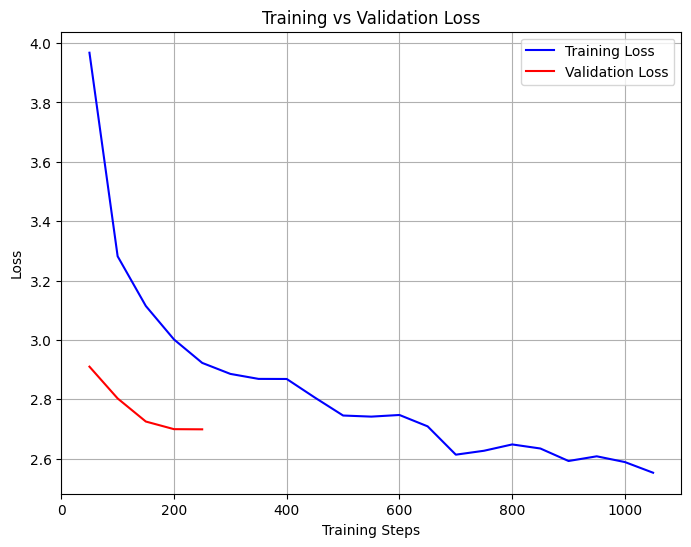

In [10]:

metrics_table = []

for log in log_history:
    if "eval_exact_match" in log:
        metrics_table.append([
            log.get("step", "-"),
            log.get("eval_exact_match", "-"),
            log.get("eval_BLEU-1", "-"),
            log.get("eval_BLEU-2", "-"),
            log.get("eval_BLEU-3", "-"),
            log.get("eval_BLEU-4", "-"),
            log.get("eval_ROUGE-L", "-")
        ])

metrics_df = pd.DataFrame(metrics_table, columns=["Step", "Exact Match", "BLEU-1", "BLEU-2", "BLEU-3", "BLEU-4", "ROUGE-L"])
print(metrics_df)

# Tracer uniquement la courbe de perte
train_loss, eval_loss, steps = [], [], []
for log in log_history:
    if "loss" in log:
        train_loss.append(log["loss"])
        steps.append(log["step"])
    if "eval_loss" in log:
        eval_loss.append(log["eval_loss"])

plt.figure(figsize=(8, 6))
plt.plot(steps, train_loss, label="Training Loss", color="blue")
plt.plot(steps[:len(eval_loss)], eval_loss, label="Validation Loss", color="red")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
model_path = "/kaggle/working/t5_chatbot_model"
tokenizer_path = "/kaggle/working/t5_chatbot_tokenizer"


tokenizer = T5Tokenizer.from_pretrained(tokenizer_path)
model = T5ForConditionalGeneration.from_pretrained(model_path)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def generate_response_top_k_top_p(
    question, model, tokenizer, max_length=64, top_k=50, top_p=0.95, temperature=1.0
):
   
    try:
        
        formatted_question = f"Answer the following question: {question}"
        
        
        inputs = tokenizer(
            formatted_question,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=128,
        ).to(device)

        
        outputs = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_length=max_length,
            do_sample=True,  
            top_k=top_k, 
            top_p=top_p,  
            temperature=temperature,  
            pad_token_id=tokenizer.pad_token_id,
        )

        
        response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        S
        return response if response else "No response generated."

    except Exception as e:
        return f"Error: {str(e)}"


test_questions = [
    "What is Alzheimer's disease?",
    "How does the immune system work?",
    "What are the symptoms of diabetes?",
    "How can I prevent heart disease?",
]


for question in test_questions:
    response = generate_response_top_k_top_p(question, model, tokenizer)
    print("\n" + "=" * 60)
    print(f"🔹 **Question:** {question}")
    print(f"💡 **Response:** {response}")
print("=" * 60)



🔹 **Question:** What is Alzheimer's disease?
💡 **Response:** Alzheimers disease is a dementia that causes an impairment of memory that lasts for years. if Alzheimer's disease is not controlled, it may not cause symptoms. the disease can be inherited, inherited, orinherited. it generally does not cause symptoms or symptoms at all. in some cases,

🔹 **Question:** How does the immune system work?
💡 **Response:** the immune system is a system of cells that protect against infection and disease. in the body, the immune system releases immune-system signaling, or idylischen molecules, that attack, neutralize, and destroy bacteria, viruses, and invade healthy tissues. the immune system also protects cells

🔹 **Question:** What are the symptoms of diabetes?
💡 **Response:** if you have diabetes, you may feel very sick or feel sick from the moment the diabetes occurs. those that have no symptoms or severe symptoms may experience: - insecuting pain - pain or tightness in the abdomen or legs - na